In [182]:
import subprocess
from multiprocessing import Pool
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%run averaging.ipynb
%run optimize_slope.ipynb

In [2]:
vol_er = (3.9*0.1*0.1)
vol_cyt = (4.0*0.5*0.5-vol_er)
vol_tot = vol_cyt + vol_er
N_avo=6.0221409e23

In [72]:
def write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True):
    ftext = """sprintf(my_seed,"%05g",SEED)

    iterations = e3

    INCLUDE_FILE = "../outputLoc.mdl"
    INCLUDE_FILE = "../initialization.mdl"
    INCLUDE_FILE = "parameters.mdl"
    /* Modifications in Parameters */
        VDCC_number_presynaptic = 40

        n_Glu_neuron =  1 //2000
        GluT_density_astrocyte = 0.1 //1000

        ca_conc_presynaptic_er = e-6     //initial ER conc specified here!!!!!
        //ryr_number_presynaptic = 0 //no RYR

    f =                                 //SERCA parameter adjustments here!!!!!!!!!!

    sm = //multiply all serca parameters

    /*Initial SERCA fractions*/
    serca_x1_feq = 
    serca_x1a_feq = 
    serca_x2_feq = 
    serca_y1_feq = 
    serca_y1a_feq = 
    serca_y2_feq = 

    INCLUDE_FILE = "rxn_rate_constants.mdl"
    /* Modifications in Reaction Rate Constants */
    //k_PMCA_0_1 = 0
    //k_PMCA_0_leak = 0


    /* Output Folder */
            //isi = "40"
        sprintf(VDCC, "%g", VDCC_number_presynaptic)
        sprintf(f_mult, "%g", f) 
        sprintf(s_mult, "%g", sm) 
        sprintf(init_er_conc, "%g", ca_conc_presynaptic_er*1e6)   	
        fname = 

        output_folder = outputLoc & "ppf/" & fname & "/sm" & s_mult & "/" & f_mult & "/" & init_er_conc & "/s_" & my_seed

    /* Rates for P/Q-type Voltage Dependent Calcium Channels */
    /* From Bischoffberger et al., 2005, , Biophys. J.*/

        k_VDCC_PQ_C01 = 0
        k_VDCC_PQ_C12 = 0
        k_VDCC_PQ_C23 = 0
        k_VDCC_PQ_C34 = 0
        k_VDCC_PQ_C43 = 0
        k_VDCC_PQ_C32 = 0
        k_VDCC_PQ_C21= 0
        k_VDCC_PQ_C10 = 0
        k_VDCC_PQ_Ca = 0

    INCLUDE_FILE = "triggered_release.inc.mdl"

    INCLUDE_FILE = "rxn_outputRS.mdl"
    //INCLUDE_FILE = "viz_output.mdl"
    """
    ftext=ftext.replace('iterations = ', 'iterations = '+str(iterations))
    ftext=ftext.replace('sm = ', 'sm = '+str(sm))
    ftext=ftext.replace('ca_conc_presynaptic_er = ', 'ca_conc_presynaptic_er = '+str(ic))
    ftext=ftext.replace('f = ','f = '+str(sf))
    ftext=ftext.replace('fname = ','fname = '+'"'+str(outfolder)+'"')
    for i,p in enumerate(['x1','x1a','x2','y2','y1a','y1']):
        old="serca_"+p+"_feq = "
        new="serca_"+p+"_feq = "+str(serca_frac[i])
        ftext=ftext.replace(old,new)
    if write:
        with open(file_name,'w') as wfile:
            wfile.write(ftext)


In [ ]:
#write .mdls for sf=4.3 equilibrium at 750uM
sf=4.3
folder="/home/kabir/Project/tripartiteSynapse/brute750_6/"
outfolder="brute6"
initial_conc=[350,450,550,650,700]
serca_frac=[0.5709841 , 0.27425674, 0.06441576, 0.04471076, 0.03791196, 0.00749021]
serca_mult=[3,4,5,6,7,8,9,10]

fnames=[]
#ic=750
iterations=20000
for ic in initial_conc:
    for sm in serca_mult:#[3.5,3.75,4,4.25,4.5,4.75]:
        file_name=folder+"RSnostim_sm"+str(sm)+"_"+str(sf)+"_"+str(ic)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)

In [237]:
ic=500
folder="/home/kabir/Project/tripartiteSynapse/brute750_6/"
outfolder="brute7"
serca_frac=[0.64657755, 0.29015902, 0.03641392, 0.01106246, 0.01186909, 0.00403319]
serca_mult=[3,6,9,12]
serca_f=[1.8,1.9]
iterations=2000
fnames=[]

for sm in serca_mult:
    for sf in serca_f:
        file_name=folder+"RSnostim_sm"+str(sm)+"_"+str(sf)+"_"+str(ic)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)

In [240]:
ic=750
folder="/home/kabir/Project/tripartiteSynapse/brute750_6/"
outfolder="brute7"
serca_frac=[0.58250749, 0.28762388, 0.06026734, 0.03595298, 0.02742567,0.0061074]
serca_mult=[3,6,9,12]
serca_f=[]#[2.6,2.8,2.9,3.0,3.1]
iterations=2000
fnames=[]

for sm in serca_mult:
    for sf in serca_f:
        file_name=folder+"RSnostim_sm"+str(sm)+"_"+str(sf)+"_"+str(ic)+".mdl"
        fnames.append(file_name)
        write_mdl(file_name,outfolder,iterations,ic,sf,sm,serca_frac,write=True)

In [241]:
#write run.sh
with open(folder+'run.sh','w') as f:
    for name in fnames:
            f.write("qsub -N "+name.replace('.mdl','').replace(folder,'')+" -v I='"+name.replace(folder,'/home/subhadra/kabir/tripartiteSynapse/brute750_6/')+"' pbs.py\n")

In [242]:
#sync script files to cluster
p=subprocess.call(["rsync","-arhP",folder[:-1],"subhadra@192.168.1.244:/home/subhadra/kabir/tripartiteSynapse/"])

In [254]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/brute7","/data/kabir/output/ppf/"])

In [258]:
#average
ic=750

serca_mult=[3,6,9,12]
serca_f=[2.6,2.8,2.9,3,3.1]#[3.5,3.6,3.7]

for sm in serca_mult:
    for sf in serca_f:
        averager("/data/kabir/output/ppf/brute7/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")

In [259]:
data={}
ic=750
for sm in serca_mult:
    data[sm]={}
    for sf in serca_f:
        data_file='/data/kabir/output/ppf/brute7/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][sf]=np.loadtxt(data_file)
        data[sm][sf].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar 

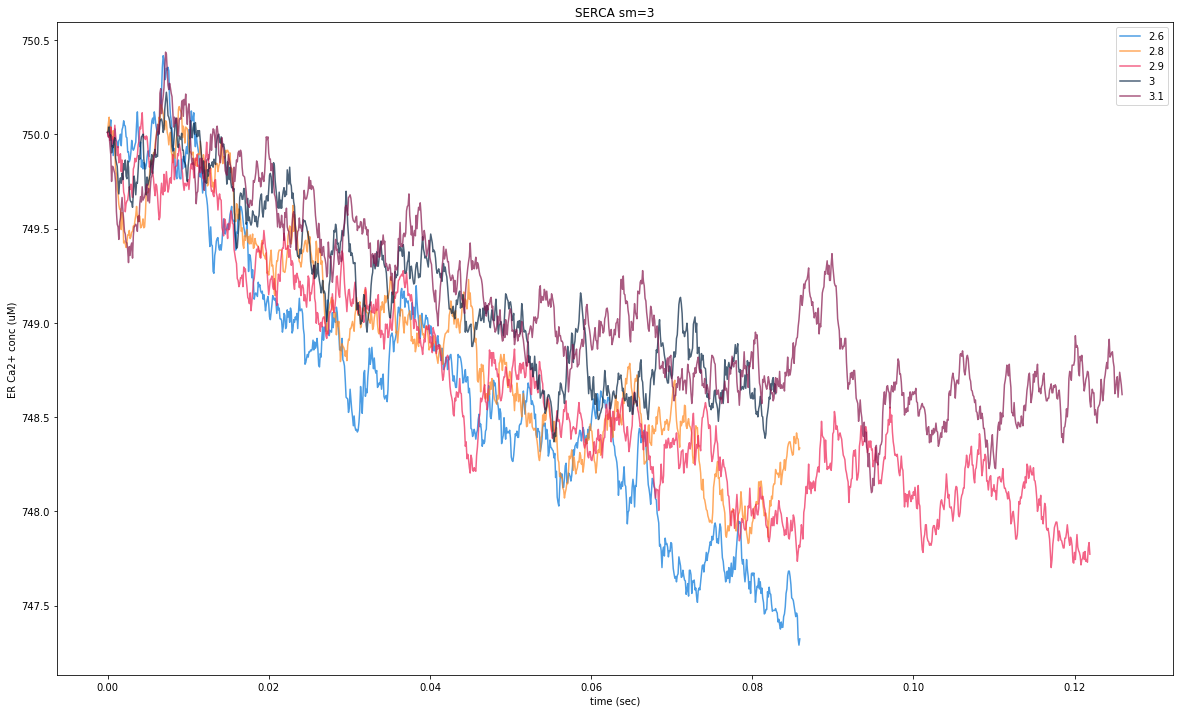

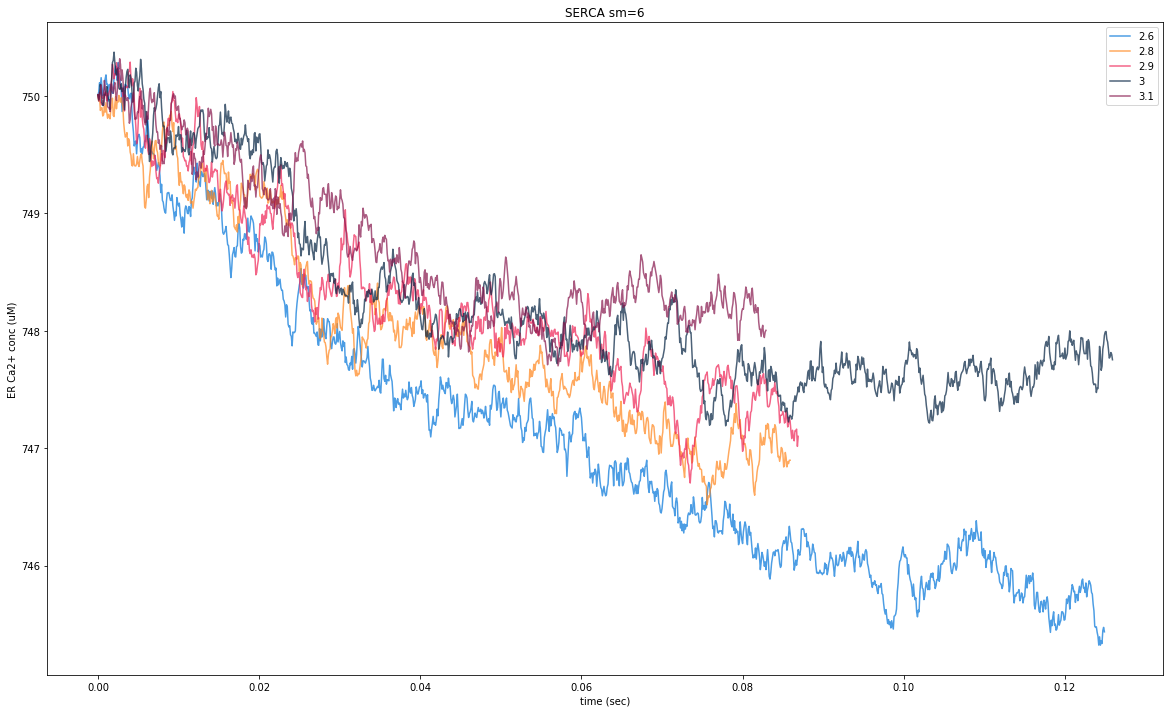

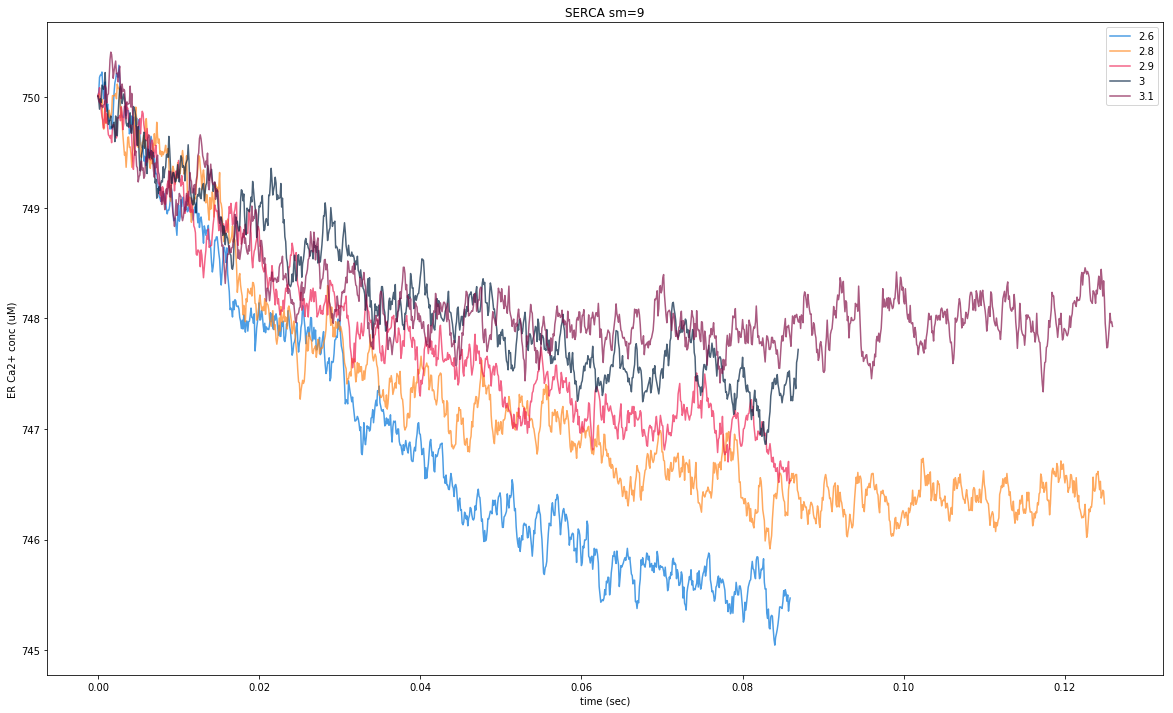

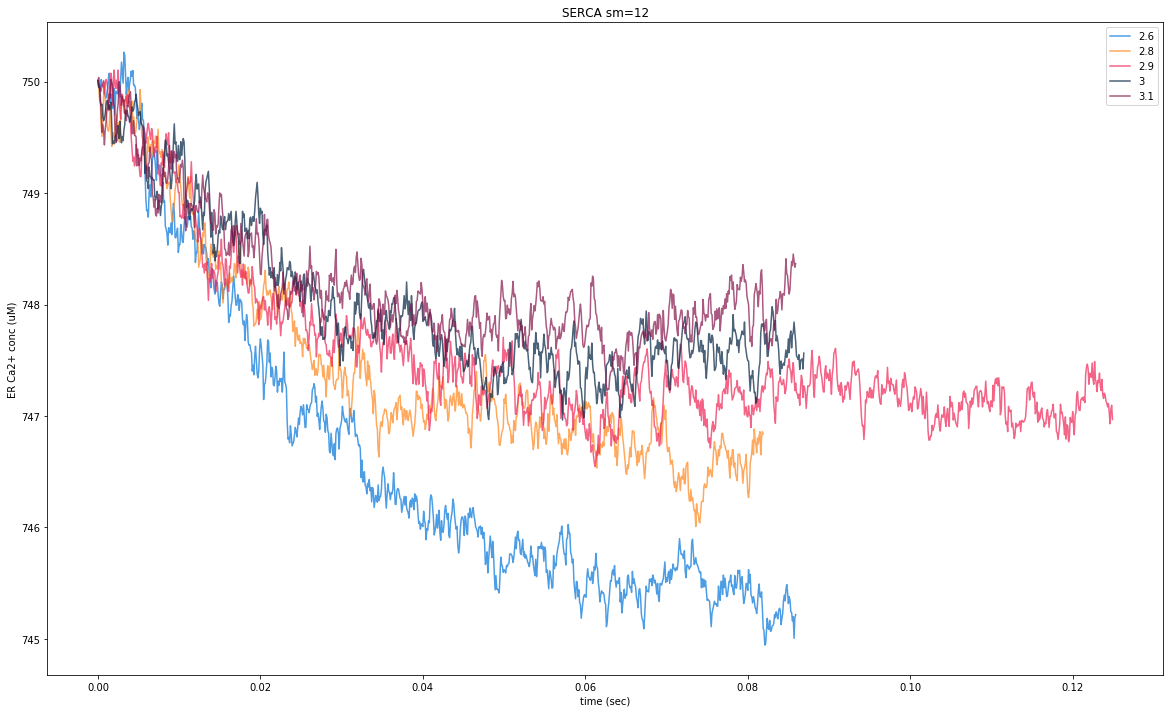

In [260]:
#plot 750
%run optimize_slope.ipynb
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

for sm in serca_mult:
    plt.figure(figsize=(20,12))
    for i,sf in enumerate(serca_f):
        ydata=data[sm][sf].T[1]
        xdata=data[sm][sf].T[0]
        #ydata = gaussian_filter1d(ydata, sigma=0)
        plt.plot(xdata,ydata,color=color[i%12],label=str(sf), alpha=0.7)
    #print("(Optimum sf, error)=",optimize_slope(data[sm],750))
    plt.legend()
    plt.title('SERCA sm='+str(sm))
    plt.xlabel('time (sec)')
    plt.ylabel('ER Ca2+ conc (uM)')
    plt.legend()
    #plt.savefig('/home/kabir/Project/plots/brute6/sm'+str(sm)+'eq'+'750'+'.eps')#"""
    #print(optimize_slope(data[sm],750))

In [233]:
#sync data back to this system
p=subprocess.call(["rsync","-arhP","subhadra@192.168.1.244:/storage/subhadra/kabir/output/ppf/brute7","/data/kabir/output/ppf/"])

In [247]:
#average
ic=500

serca_mult=[3,6,9,12]
serca_f=[2,2.1,2.2]

for sm in serca_mult:
    for sf in serca_f:
        averager("/data/kabir/output/ppf/brute7/sm"+str(sm)+"/"+str(sf)+"/"+str(ic)+"/")

In [248]:
data={}
ic=500
for sm in serca_mult:
    data[sm]={}
    for sf in serca_f:
        data_file='/data/kabir/output/ppf/brute7/sm'+str(sm)+"/"+str(sf)+'/'+str(ic)+'/Average/ca.dat'
        #print data_file
        data[sm][sf]=np.loadtxt(data_file)
        data[sm][sf].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar 

(Optimum sf, error)= (1.893966163303115, 9.395852951461269)
(Optimum sf, error)= (1.889238677790269, 7.624146544564568)
(Optimum sf, error)= (1.8177105143255363, 8.766927797196017)
(Optimum sf, error)= (1.7815885601594195, 7.929022301061068)


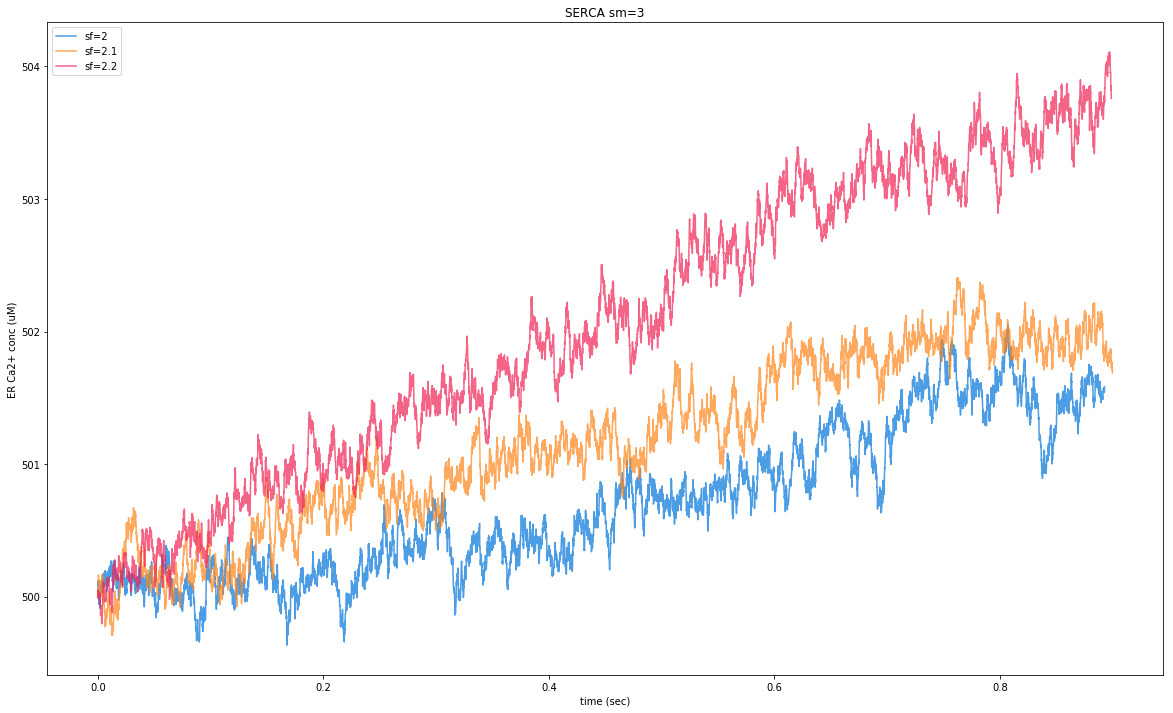

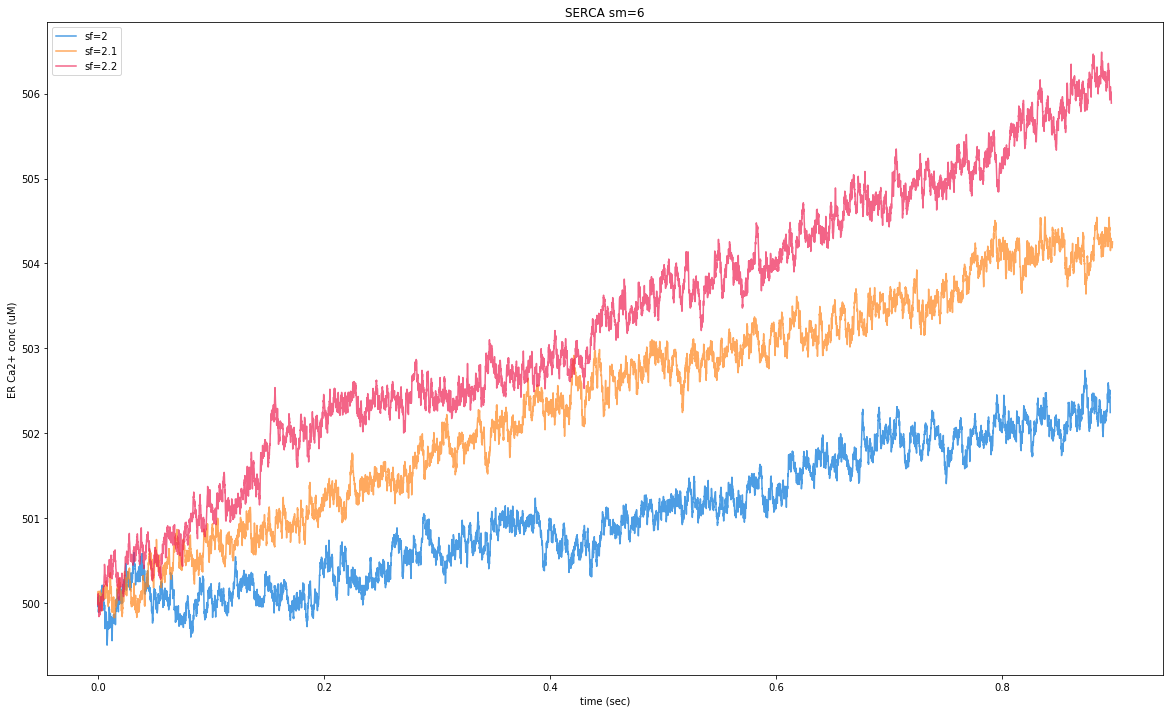

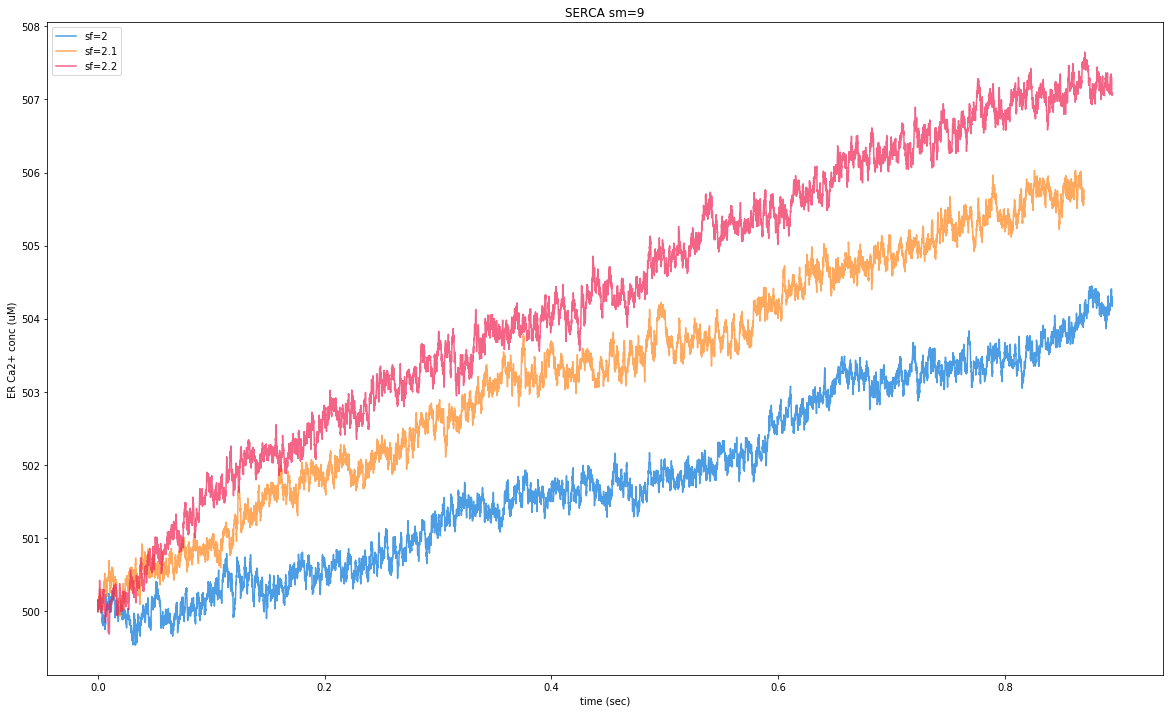

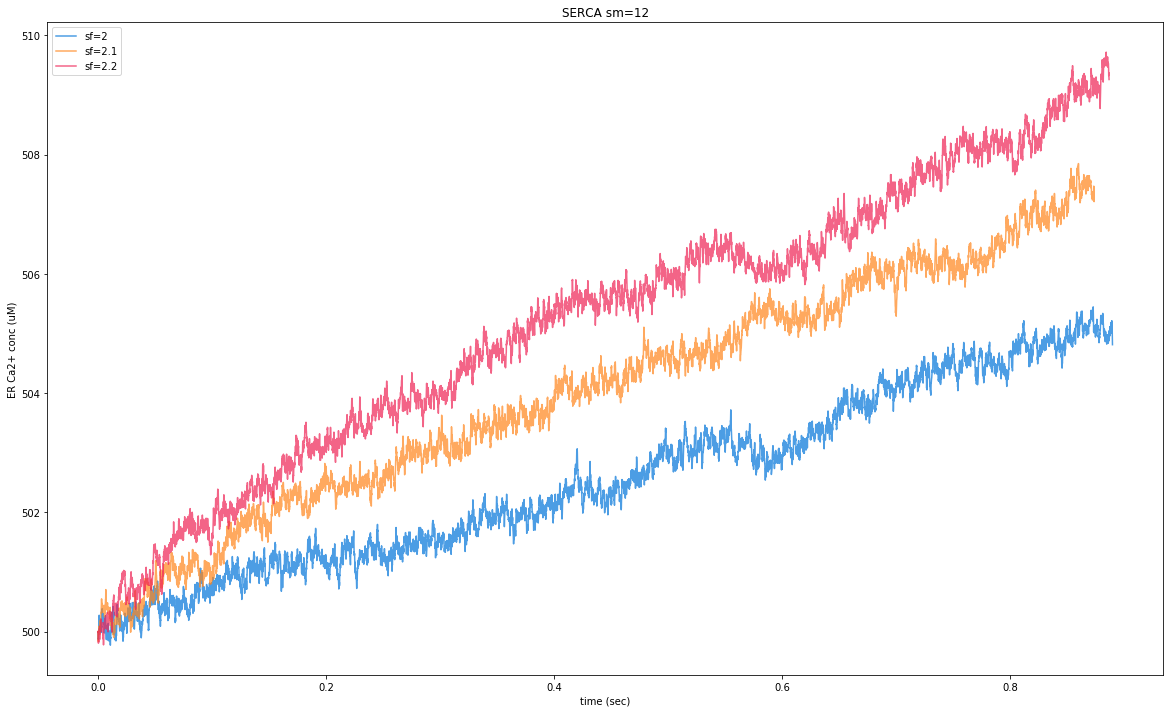

In [249]:
#plot
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]
sm=3


for sm in serca_mult:
    plt.figure(figsize=(20,12))
    for i,sf in enumerate(serca_f):
        ydata=data[sm][sf].T[1]
        xdata=data[sm][sf].T[0]
        #ydata = gaussian_filter1d(ydata, sigma=0)
        plt.plot(xdata,ydata,color=color[i%12],label='sf='+str(sf), alpha=0.7)
    plt.legend()
    plt.title('SERCA sm='+str(sm))
    plt.xlabel('time (sec)')
    plt.ylabel('ER Ca2+ conc (uM)')
    plt.savefig('/home/kabir/Project/plots/brute6/sm'+str(sm)+'eq'+'500'+'.eps')
    print("(Optimum sf, error)=",optimize_slope(data[sm],500))

In [97]:
#average the data over seeds
initial_conc=[350,450,550,650,700]

#averager("/data/kabir/output/ppf/brute6/4.3/350")
sf=4.3
for ic in initial_conc:
    #print(sm,ic)
    averager("/data/kabir/output/ppf/brute6/"+str(sf)+"/"+str(ic)+"/")

In [58]:
# 750 load data
color=["#0074D9", "#FF851B", "#EE2255", "#001f3f", "#85144b", "#39CCCC", "#FFDC00",
       "#2ECC40", "#7FDBFF", "#B10DC9", "#3D9970", "#AAAAAA", "#000000"]

data={}

initial_conc=[350,450,550,650,700]
sf=4.3


for ic in initial_conc:
    data_file='/data/kabir/output/ppf/brute6/'+str(sf)+'/'+str(ic)+'/Average/ca.dat'
    #print data_file
    data[ic]=np.loadtxt(data_file)

    data[ic].T[1]*=1e15/N_avo/vol_er*1e6 #micromolar    

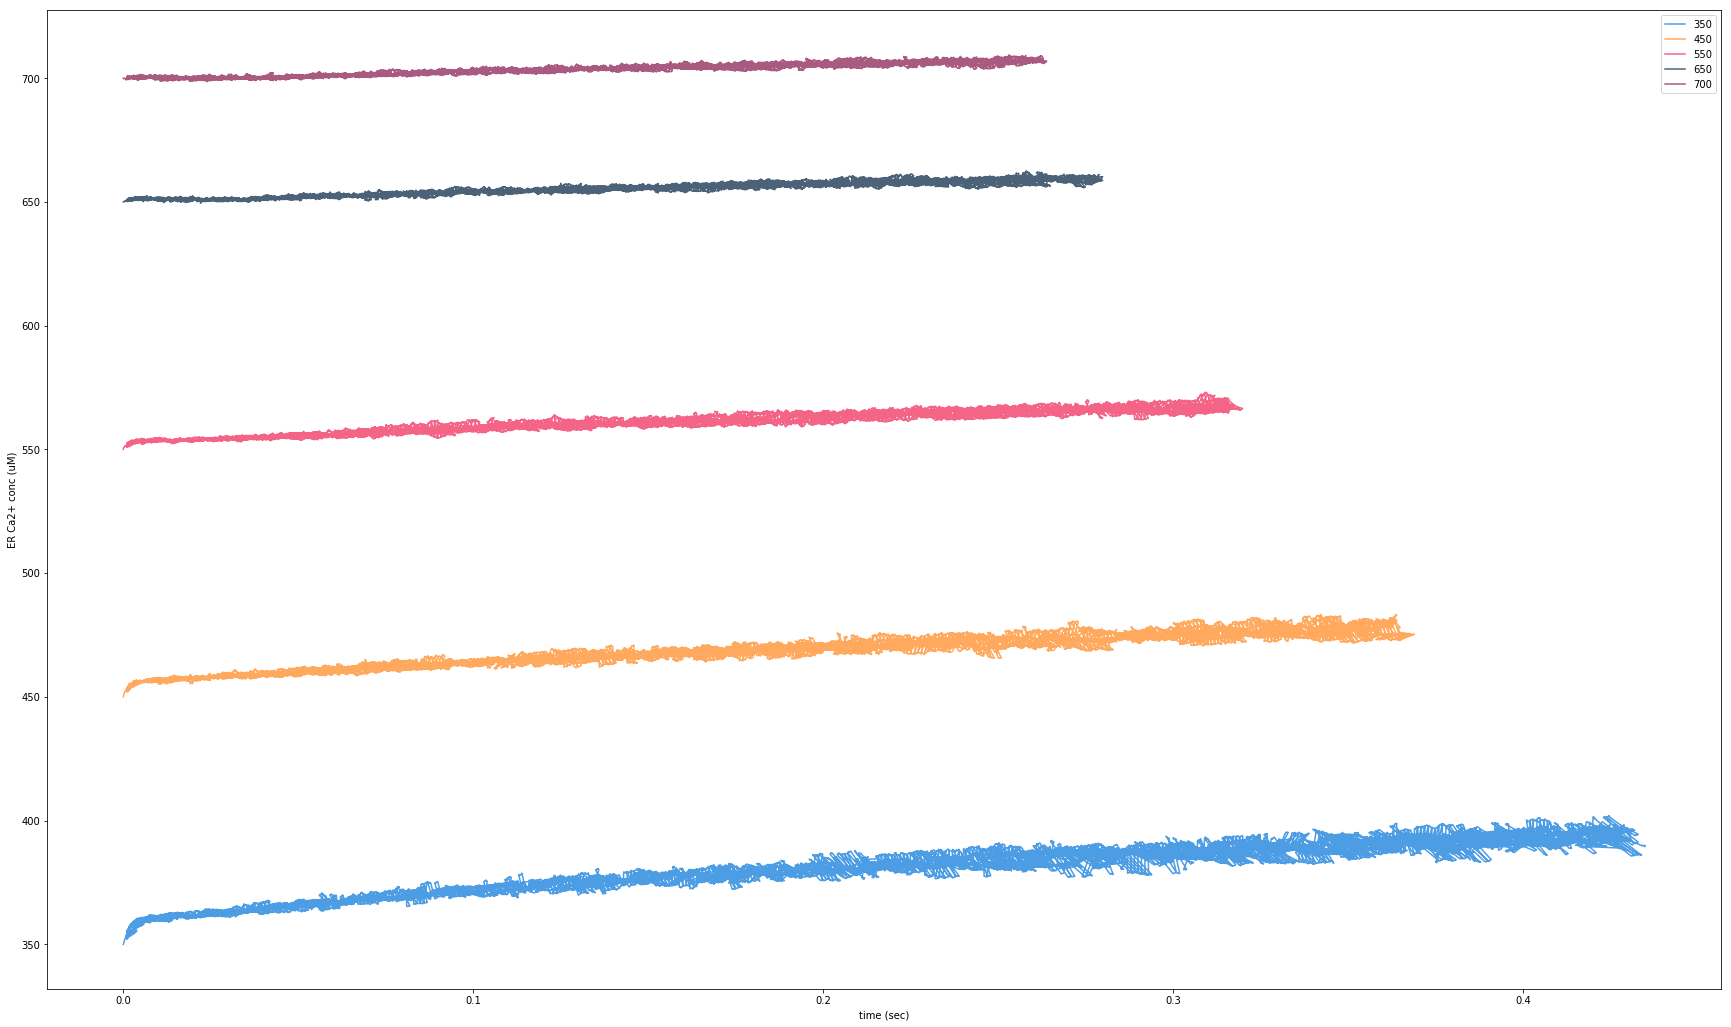

In [59]:
#plot 750 plots
plt.figure(figsize=(30,18))

for i,ic in enumerate(initial_conc):
    ydata=data[ic].T[1]
    xdata=data[ic].T[0]
    #ydata = gaussian_filter1d(ydata, sigma=0)
    plt.plot(xdata,ydata,color=color[i%12],label=str(ic), alpha=0.7)
    
    b="""popt,pcov=curve_fit(line_fit,xdata,ydata)
    fit.append(popt)
    var.append(pcov[0][0])
    xdata = np.linspace(0, 1.4, 50)
    plt.plot(xdata, line_fit(xdata, *fit[i]), color=color[i])"""
    
plt.xlabel('time (sec)')
plt.ylabel('ER Ca2+ conc (uM)')
plt.legend()    
plt.savefig('/home/kabir/Project/plots/brute5/serca_f'+str(ic)+'.eps') 

In [55]:
l=data[350].T[0]
print(all([l[i] <= l[i+1] for i in range(len(l)-1)]))

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 

In [193]:
list(data.keys())

[3, 6, 9, 12]